In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import random
import PIL
print("TensorFlow version:", tf.__version__)

DATA_DIR = Path("/kaggle/input/garbage-classification-v2/garbage-dataset")
WORK_DIR = Path("/kaggle/working")
SAVED_DIR = WORK_DIR / "saved_models"
ARTIFACTS_DIR = WORK_DIR / "artifacts"
SAVED_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123
EPOCHS = 30
FINE_TUNE_EPOCHS = 15

AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


TensorFlow version: 2.18.0


Found classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Counts per class: {'battery': 944, 'biological': 997, 'cardboard': 1825, 'clothes': 5327, 'glass': 3061, 'metal': 1020, 'paper': 1680, 'plastic': 1984, 'shoes': 1977, 'trash': 947}


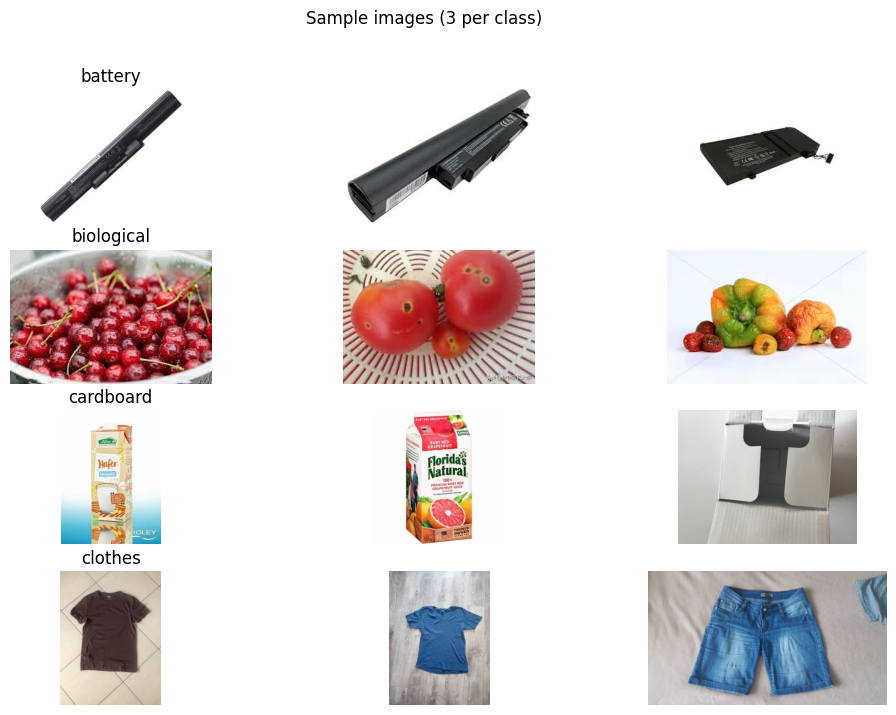

In [2]:
from pathlib import Path
assert DATA_DIR.exists(), f"Dataset not found at {DATA_DIR} - update DATA_DIR in Cell [1]"

class_dirs = sorted([p for p in DATA_DIR.iterdir() if p.is_dir()])
class_names = [p.name for p in class_dirs]
print("Found classes:", class_names)

counts = {}
for p in class_dirs:
    cnt = len(list(p.glob("*")))
    counts[p.name] = cnt
print("Counts per class:", counts)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sample_classes = class_names[:4]
i = 1
for cls in sample_classes:
    imgs = list((DATA_DIR / cls).glob("*"))[:3]
    for img_path in imgs:
        plt.subplot(len(sample_classes), 3, i)
        plt.imshow(PIL.Image.open(img_path))
        plt.axis("off")
        if i % 3 == 1:
            plt.title(cls)
        i += 1
plt.suptitle("Sample images (3 per class)")
plt.show()

In [3]:
_raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.20,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

_raw_val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.20,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = _raw_train_ds.class_names
num_classes = len(class_names)

train_ds = _raw_train_ds.shuffle(1000).prefetch(AUTOTUNE)

val_batches = []
test_batches = []
for i, batch in enumerate(_raw_val_test_ds):
    if i % 2 == 0:
        val_batches.append(batch)
    else:
        test_batches.append(batch)

def flatten_batches(batches):
    imgs = []
    labels = []
    for images, labs in batches:
        imgs.append(images.numpy())
        labels.append(labs.numpy())
    if not imgs:
        return np.array([]), np.array([])
    imgs = np.concatenate(imgs, axis=0)
    labels = np.concatenate(labels, axis=0)
    return imgs, labels

x_val, y_val = flatten_batches(val_batches)
x_test, y_test = flatten_batches(test_batches)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val samples:", x_val.shape[0])
print("Test samples:", x_test.shape[0])
print("Class names:", class_names)

Found 19762 files belonging to 10 classes.
Using 15810 files for training.


I0000 00:00:1763465672.967968      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 19762 files belonging to 10 classes.
Using 3952 files for validation.
Train batches: 495
Val samples: 1984
Test samples: 1968
Class names: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [4]:
from math import floor
from sklearn.utils.class_weight import compute_class_weight

counts = {}
for cls in class_names:
    p = DATA_DIR / cls
    files = [f for f in p.iterdir() if f.is_file()]
    counts[cls] = len(files)

print("Total files per class (on disk):")
for k,v in counts.items():
    print(f"  {k}: {v}")

train_counts = {cls: int(floor(cnt * 0.80)) for cls, cnt in counts.items()}
print("\nEstimated training files per class (80% split):")
for k,v in train_counts.items():
    print(f"  {k}: {v}")

y_for_weights = []
for i, cls in enumerate(class_names):
    y_for_weights.extend([i] * train_counts[cls])
y_for_weights = np.array(y_for_weights)

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.arange(len(class_names)),
                                     y=y_for_weights)
class_weight_dict = {i: float(w) for i, w in enumerate(class_weights)}
print("\nClass weight dictionary (used during training):")
print(class_weight_dict)


Total files per class (on disk):
  battery: 944
  biological: 997
  cardboard: 1825
  clothes: 5327
  glass: 3061
  metal: 1020
  paper: 1680
  plastic: 1984
  shoes: 1977
  trash: 947

Estimated training files per class (80% split):
  battery: 755
  biological: 797
  cardboard: 1460
  clothes: 4261
  glass: 2448
  metal: 816
  paper: 1344
  plastic: 1587
  shoes: 1581
  trash: 757

Class weight dictionary (used during training):
{0: 2.0935099337748344, 1: 1.9831869510664994, 2: 1.0826027397260274, 3: 0.3709457873738559, 4: 0.6456699346405229, 5: 1.9370098039215686, 6: 1.1760416666666667, 7: 0.9959672337744171, 8: 0.9997469955724225, 9: 2.0879788639365917}


In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False, input_shape=(*IMG_SIZE,3), weights="imagenet")
base_model.trainable = False

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
])

inputs = layers.Input(shape=(*IMG_SIZE,3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,077 (16.71 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
import shutil
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import math
import gc
import tensorflow as tf

NEW_BATCH_SIZE = 16
REENCODE_QUALITY = 90
CLEAN_DIR = WORK_DIR / "clean_dataset_jpeg"
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

print("Re-encoding all images into JPEGs at:", CLEAN_DIR)
allowed_input_ext = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp"}

total = 0
failed = 0

for cls in class_names:
    src_dir = DATA_DIR / cls
    dst_dir = CLEAN_DIR / cls
    dst_dir.mkdir(parents=True, exist_ok=True)
    for f in src_dir.iterdir():
        if not f.is_file():
            continue
        total += 1
        try:
            with Image.open(f) as im:
                im_converted = im.convert("RGB")
                out_name = f.stem + ".jpg"
                out_path = dst_dir / out_name
                im_converted.save(out_path, format="JPEG", quality=REENCODE_QUALITY)
        except (UnidentifiedImageError, OSError, ValueError) as e:
            bad_dir = WORK_DIR / "corrupt_files_jpeg" / cls
            bad_dir.mkdir(parents=True, exist_ok=True)
            shutil.copy2(f, bad_dir / f.name)
            failed += 1

print(f"Re-encoding finished. Processed: {total} files, Failed: {failed} (moved to corrupt_files_jpeg).")

gc.collect()
tf.keras.backend.clear_session()

print("Creating image datasets from re-encoded JPEG dataset...")
_raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    CLEAN_DIR,
    validation_split=0.20,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=NEW_BATCH_SIZE
)

_raw_val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    CLEAN_DIR,
    validation_split=0.20,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=NEW_BATCH_SIZE
)

class_names = _raw_train_ds.class_names
num_classes = len(class_names)
print("Classes (jpeg-clean):", class_names)

train_ds = _raw_train_ds.shuffle(1000).prefetch(AUTOTUNE)

val_batches = []
test_batches = []
for i, batch in enumerate(_raw_val_test_ds):
    if i % 2 == 0:
        val_batches.append(batch)
    else:
        test_batches.append(batch)

def flatten_batches(batches):
    imgs = []
    labels = []
    for images, labs in batches:
        imgs.append(images.numpy())
        labels.append(labs.numpy())
    if not imgs:
        return np.array([]), np.array([])
    imgs = np.concatenate(imgs, axis=0)
    labels = np.concatenate(labels, axis=0)
    return imgs, labels

x_val, y_val = flatten_batches(val_batches)
x_test, y_test = flatten_batches(test_batches)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(NEW_BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(NEW_BATCH_SIZE).prefetch(AUTOTUNE)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val samples:", x_val.shape[0])
print("Test samples:", x_test.shape[0])

counts = {}
for cls in class_names:
    p = CLEAN_DIR / cls
    files = [f for f in p.iterdir() if f.is_file()]
    counts[cls] = len(files)
print("JPEG-clean counts per class:", counts)

from sklearn.utils.class_weight import compute_class_weight
train_counts = {cls: int(math.floor(cnt * 0.80)) for cls, cnt in counts.items()}
y_for_weights = []
for i, cls in enumerate(class_names):
    y_for_weights.extend([i] * train_counts[cls])
y_for_weights = np.array(y_for_weights)
class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(len(class_names)), y=y_for_weights)
class_weight_dict = {i: float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

checkpoint_path = str(SAVED_DIR / "garbage_efficientnet_best.h5")
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

print(f"Starting training with batch size = {NEW_BATCH_SIZE} ...")
try:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        class_weight=class_weight_dict,
        callbacks=callbacks
    )
    np.save(ARTIFACTS_DIR / "history.npy", history.history)
    print("Training completed (head).")
except tf.errors.ResourceExhaustedError as oom_err:
    print("ResourceExhaustedError during training (likely OOM).")
    print("Suggestion: reduce NEW_BATCH_SIZE (e.g., to 8 or 4), or reduce IMG_SIZE, or switch to a smaller backbone.")
    raise oom_err

Re-encoding all images into JPEGs at: /kaggle/working/clean_dataset_jpeg
Re-encoding finished. Processed: 19762 files, Failed: 0 (moved to corrupt_files_jpeg).
Creating image datasets from re-encoded JPEG dataset...
Found 19731 files belonging to 10 classes.
Using 15785 files for training.
Found 19731 files belonging to 10 classes.
Using 3946 files for validation.
Classes (jpeg-clean): ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Train batches: 987
Val samples: 1978
Test samples: 1968
JPEG-clean counts per class: {'battery': 944, 'biological': 997, 'cardboard': 1824, 'clothes': 5326, 'glass': 3054, 'metal': 1016, 'paper': 1678, 'plastic': 1976, 'shoes': 1977, 'trash': 939}
Class weights: {0: 2.090066225165563, 1: 1.9799247176913426, 2: 1.0815627141878, 3: 0.3704225352112676, 4: 0.645927138763815, 5: 1.9433497536945812, 6: 1.1758569299552906, 7: 0.9987341772151899, 8: 0.9981024667931688, 9: 2.1011984021304926}
Starting trainin

E0000 00:00:1763465919.465767      48 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1763465941.982139     127 cuda_dnn.cc:529] Loaded cuDNN version 90300


986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8294 - loss: 0.6074
Epoch 1: val_accuracy improved from -inf to 0.94388, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 69s 37ms/step - accuracy: 0.8295 - loss: 0.6070 - val_accuracy: 0.9439 - val_loss: 0.1750 - learning_rate: 0.0010
Epoch 2/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9191 - loss: 0.2601
Epoch 2: val_accuracy improved from 0.94388 to 0.94995, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - accuracy: 0.9191 - loss: 0.2601 - val_accuracy: 0.9499 - val_loss: 0.1616 - learning_rate: 0.0010
Epoch 3/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9352 - loss: 0.2059
Epoch 3: val_accuracy did not improve from 0.94995
987/987 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.9352 - loss: 0.2059 - val_accuracy: 0.9464 - val_loss: 0.1539 - learning_rate: 0.0010
Epoch 4/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9447 - loss: 0.1752
Epoch 4: val_accuracy did not improve from 0.94995
987/987 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.9447 - loss: 0.1752 - val_accuracy: 0.9494 - val_loss: 0.1525 - learning_rate: 0.0010
Epoch 5/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9503 - loss: 0.1508
Epoch 5: val_accuracy improved from 0.94995 to 0.95602, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.9503 - loss: 0.1508 - val_accuracy: 0.9560 - val_loss: 0.1377 - learning_rate: 0.0010
Epoch 6/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9529 - loss: 0.1364
Epoch 6: val_accuracy did not improve from 0.95602
987/987 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.9528 - loss: 0.1364 - val_accuracy: 0.9545 - val_loss: 0.1341 - learning_rate: 0.0010
Epoch 7/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9581 - loss: 0.1294
Epoch 7: val_accuracy did not improve from 0.95602
987/987 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.9581 - loss: 0.1294 - val_accuracy: 0.9555 - val_loss: 0.1408 - learning_rate: 0.0010
Epoch 8/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9594 - loss: 0.1143
Epoch 8: val_accuracy improved from 0.95602 to 0.96107, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.9594 - loss: 0.1143 - val_accuracy: 0.9611 - val_loss: 0.1376 - learning_rate: 0.0010
Epoch 9/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9625 - loss: 0.1035
Epoch 9: val_accuracy improved from 0.96107 to 0.96360, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.9625 - loss: 0.1035 - val_accuracy: 0.9636 - val_loss: 0.1272 - learning_rate: 0.0010
Epoch 10/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9653 - loss: 0.1006
Epoch 10: val_accuracy did not improve from 0.96360
987/987 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.9653 - loss: 0.1006 - val_accuracy: 0.9621 - val_loss: 0.1257 - learning_rate: 0.0010
Epoch 11/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9661 - loss: 0.0951
Epoch 11: val_accuracy improved from 0.96360 to 0.96613, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.9661 - loss: 0.0951 - val_accuracy: 0.9661 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 12/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9708 - loss: 0.0867
Epoch 12: val_accuracy did not improve from 0.96613
987/987 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.9708 - loss: 0.0867 - val_accuracy: 0.9646 - val_loss: 0.1289 - learning_rate: 0.0010
Epoch 13/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9728 - loss: 0.0800
Epoch 13: val_accuracy did not improve from 0.96613

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
987/987 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.9728 - loss: 0.0800 - val_accuracy: 0.9621 - val_loss: 0.1354 - learning_rate: 0.0010
Epoch 14/30
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9734 - loss: 0.0736
Epoch 14: val_accuracy did not improve from 0.96613
987/987 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.9734 - loss: 0.0

In [7]:
import tensorflow as tf
import numpy as np
import math
import gc

tf.keras.backend.clear_session()
gc.collect()

try:
    base_model
except NameError:
    raise RuntimeError("base_model not found. Make sure you ran Cell [5] to build the model before fine-tuning.")

UNFREEZE_LAST_N = 30
fine_tune_at = max(0, len(base_model.layers) - UNFREEZE_LAST_N)

base_model.trainable = True
for i, layer in enumerate(base_model.layers):
    layer.trainable = True if i >= fine_tune_at else False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print(f"Fine-tuning from layer index {fine_tune_at} / total layers {len(base_model.layers)}")
print("Trainable layers in base model (last 10 shown):")
print([ (i, l.name, l.trainable) for i,l in enumerate(base_model.layers[-10:]) ])

checkpoint_path = str(SAVED_DIR / "garbage_efficientnet_best.h5")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

print("Starting fine-tuning... (this may take longer per epoch)")

try:
    fine_history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FINE_TUNE_EPOCHS,
        class_weight=class_weight_dict,
        callbacks=callbacks
    )

    try:
        history
        for k in fine_history.history:
            history.history.setdefault(k, []).extend(fine_history.history[k])
        np.save(ARTIFACTS_DIR / "history.npy", history.history)
    except NameError:
        np.save(ARTIFACTS_DIR / "history.npy", fine_history.history)

    FINAL_MODEL_PATH = SAVED_DIR / "garbage_efficientnet_finetuned.h5"
    model.save(FINAL_MODEL_PATH)
    print("Fine-tuning complete. Saved fine-tuned model to:", FINAL_MODEL_PATH)

except tf.errors.ResourceExhaustedError as oom:
    print("ResourceExhaustedError during fine-tuning (likely GPU OOM).")
    print("Options to recover:")
    print(" - Reduce UNFREEZE_LAST_N (fewer layers trainable).")
    print(" - Reduce NEW_BATCH_SIZE in the re-encoding/train cell (try 8 or 4).")
    print(" - Reduce IMG_SIZE in Cell [1] (e.g., 160 or 192).")
    print(" - Switch to a smaller backbone (EfficientNetB0 -> MobileNetV2 or EfficientNetLite).")
    raise oom

Fine-tuning from layer index 208 / total layers 238
Trainable layers in base model (last 10 shown):
[(0, 'block7a_se_squeeze', True), (1, 'block7a_se_reshape', True), (2, 'block7a_se_reduce', True), (3, 'block7a_se_expand', True), (4, 'block7a_se_excite', True), (5, 'block7a_project_conv', True), (6, 'block7a_project_bn', True), (7, 'top_conv', True), (8, 'top_bn', True), (9, 'top_activation', True)]
Starting fine-tuning... (this may take longer per epoch)
Epoch 1/15


E0000 00:00:1763466662.342924      48 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8609 - loss: 0.5169
Epoch 1: val_accuracy improved from -inf to 0.94085, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.8609 - loss: 0.5169 - val_accuracy: 0.9408 - val_loss: 0.2362 - learning_rate: 1.0000e-05
Epoch 2/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8892 - loss: 0.3683
Epoch 2: val_accuracy improved from 0.94085 to 0.95046, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.8892 - loss: 0.3683 - val_accuracy: 0.9505 - val_loss: 0.2008 - learning_rate: 1.0000e-05
Epoch 3/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9061 - loss: 0.2920
Epoch 3: val_accuracy improved from 0.95046 to 0.95349, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.9061 - loss: 0.2920 - val_accuracy: 0.9535 - val_loss: 0.1848 - learning_rate: 1.0000e-05
Epoch 4/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9181 - loss: 0.2545
Epoch 4: val_accuracy improved from 0.95349 to 0.95450, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.9182 - loss: 0.2545 - val_accuracy: 0.9545 - val_loss: 0.1734 - learning_rate: 1.0000e-05
Epoch 5/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9223 - loss: 0.2438
Epoch 5: val_accuracy improved from 0.95450 to 0.95602, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.9223 - loss: 0.2437 - val_accuracy: 0.9560 - val_loss: 0.1634 - learning_rate: 1.0000e-05
Epoch 6/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9283 - loss: 0.2198
Epoch 6: val_accuracy did not improve from 0.95602
987/987 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.9283 - loss: 0.2198 - val_accuracy: 0.9550 - val_loss: 0.1571 - learning_rate: 1.0000e-05
Epoch 7/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9337 - loss: 0.1953
Epoch 7: val_accuracy improved from 0.95602 to 0.95804, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.9337 - loss: 0.1953 - val_accuracy: 0.9580 - val_loss: 0.1522 - learning_rate: 1.0000e-05
Epoch 8/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9374 - loss: 0.1855
Epoch 8: val_accuracy improved from 0.95804 to 0.96309, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.9374 - loss: 0.1855 - val_accuracy: 0.9631 - val_loss: 0.1440 - learning_rate: 1.0000e-05
Epoch 9/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9400 - loss: 0.1749
Epoch 9: val_accuracy did not improve from 0.96309
987/987 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.9400 - loss: 0.1749 - val_accuracy: 0.9626 - val_loss: 0.1433 - learning_rate: 1.0000e-05
Epoch 10/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9457 - loss: 0.1549
Epoch 10: val_accuracy improved from 0.96309 to 0.96461, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.9457 - loss: 0.1549 - val_accuracy: 0.9646 - val_loss: 0.1436 - learning_rate: 1.0000e-05
Epoch 11/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9460 - loss: 0.1567
Epoch 11: val_accuracy did not improve from 0.96461
987/987 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.9460 - loss: 0.1567 - val_accuracy: 0.9646 - val_loss: 0.1366 - learning_rate: 1.0000e-05
Epoch 12/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9470 - loss: 0.1582
Epoch 12: val_accuracy improved from 0.96461 to 0.96512, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.9470 - loss: 0.1582 - val_accuracy: 0.9651 - val_loss: 0.1380 - learning_rate: 1.0000e-05
Epoch 13/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9461 - loss: 0.1511
Epoch 13: val_accuracy improved from 0.96512 to 0.96714, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.9461 - loss: 0.1511 - val_accuracy: 0.9671 - val_loss: 0.1321 - learning_rate: 1.0000e-05
Epoch 14/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9499 - loss: 0.1346
Epoch 14: val_accuracy improved from 0.96714 to 0.96764, saving model to /kaggle/working/saved_models/garbage_efficientnet_best.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.9499 - loss: 0.1346 - val_accuracy: 0.9676 - val_loss: 0.1294 - learning_rate: 1.0000e-05
Epoch 15/15
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9568 - loss: 0.1246
Epoch 15: val_accuracy did not improve from 0.96764
987/987 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.9568 - loss: 0.1246 - val_accuracy: 0.9671 - val_loss: 0.1262 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 14.


Fine-tuning complete. Saved fine-tuned model to: /kaggle/working/saved_models/garbage_efficientnet_finetuned.h5


Saved model to: /kaggle/working/saved_models/garbage_efficientnet_final.h5
Running inference on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━

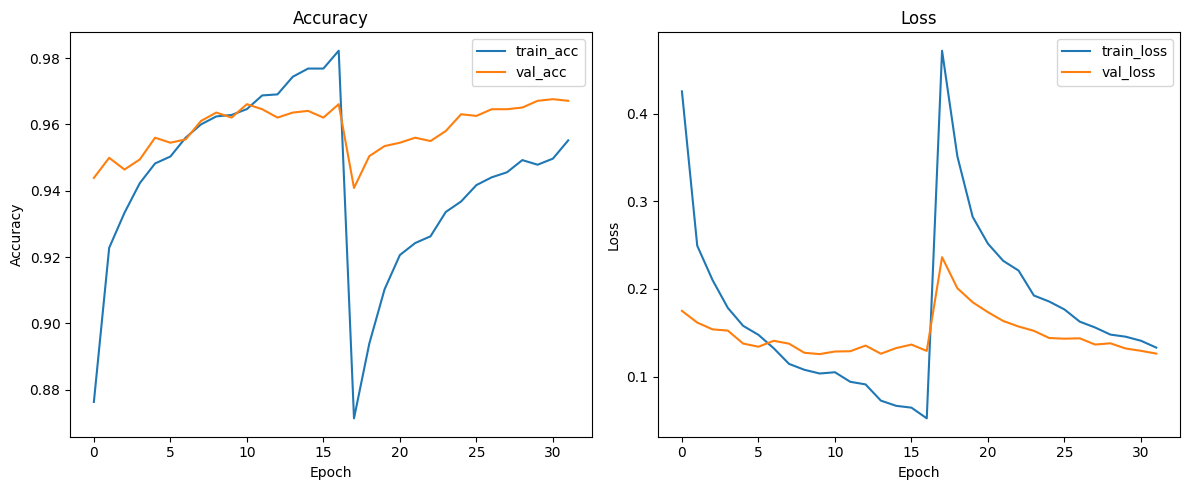

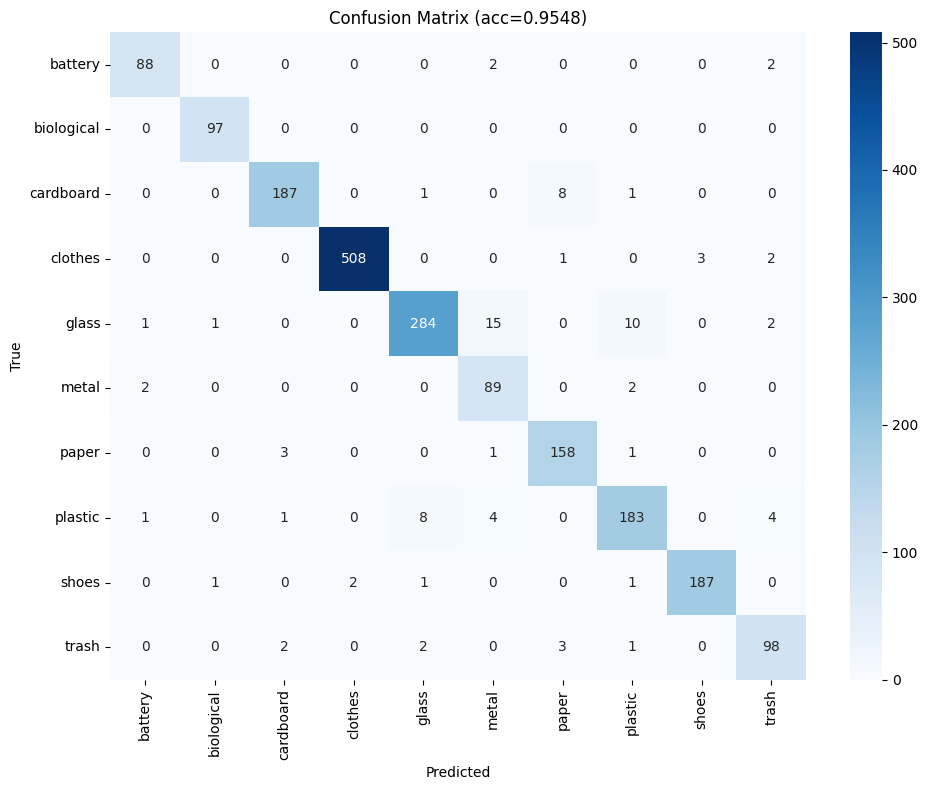

Artifacts saved to: /kaggle/working/artifacts


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import tensorflow as tf

if 'model' not in globals():
    raise RuntimeError("Model object not found. Make sure you ran Cell [5] and Cells [6-7] (training).")

if 'test_ds' not in globals():
    raise RuntimeError("test_ds not found. Make sure Cell [3] (or the cleaning cell) created test_ds.")

FINAL_MODEL_PATH = SAVED_DIR / "garbage_efficientnet_final.h5"
model.save(FINAL_MODEL_PATH)
print("Saved model to:", FINAL_MODEL_PATH)

y_true = []
y_pred = []
y_probs = []

print("Running inference on test set...")
for images, labels in test_ds:
    preds = model.predict(images)
    y_probs.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

test_acc = float(np.mean(y_true == y_pred))
print(f"Test accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)

np.save(ARTIFACTS_DIR / "confusion_matrix.npy", cm)
with open(ARTIFACTS_DIR / "class_report.txt", "w") as f:
    f.write(report)
np.save(ARTIFACTS_DIR / "labels.npy", np.array(class_names))
np.save(ARTIFACTS_DIR / "y_true.npy", y_true)
np.save(ARTIFACTS_DIR / "y_pred.npy", y_pred)

print("\nClassification report:\n")
print(report)

hist = None
if 'history' in globals():
    hist = history.history
elif (ARTIFACTS_DIR / "history.npy").exists():
    hist = np.load(ARTIFACTS_DIR / "history.npy", allow_pickle=True).item()

if hist is not None:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(hist.get("accuracy",[]), label="train_acc")
    plt.plot(hist.get("val_accuracy",[]), label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
    plt.subplot(1,2,2)
    plt.plot(hist.get("loss",[]), label="train_loss")
    plt.plot(hist.get("val_loss",[]), label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
    plt.tight_layout()
    plt.savefig(ARTIFACTS_DIR / "training_curves.png", dpi=150)
    plt.show()
else:
    print("Training history not found; skipping training curves.")

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.ylabel("True"); plt.xlabel("Predicted"); plt.title(f"Confusion Matrix (acc={test_acc:.4f})")
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "confusion_matrix.png", dpi=150)
plt.show()

print("Artifacts saved to:", ARTIFACTS_DIR)

In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
from pathlib import Path
import tensorflow as tf

def predict_image(img_path, model, class_names, img_size=IMG_SIZE, top_k=3):
    """
    Predict a single image path (string or Path). Returns preds array and prints top_k.
    """
    img_path = Path(img_path)
    img = Image.open(img_path).convert("RGB").resize(img_size)
    x = np.array(img)[None, ...].astype("float32")
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    preds = model.predict(x)[0]
    top_idx = np.argsort(preds)[::-1][:top_k]
    print("Top predictions:")
    for i in top_idx:
        print(f"  {class_names[i]} — {preds[i]*100:.2f}%")
    return preds, img

def batch_predict_folder(folder_path, model, class_names, n_show=9):
    folder = Path(folder_path)
    files = [p for p in folder.glob("*") if p.is_file()]
    if len(files) == 0:
        print("No files found in", folder_path)
        return
    sample_files = files[:n_show]
    cols = int(np.ceil(np.sqrt(len(sample_files))))
    plt.figure(figsize=(cols*3, cols*3))
    for i, f in enumerate(sample_files):
        preds, img = predict_image(f, model, class_names, show=False) if False else (None, None)
        # we will compute preds below without printing
        img = Image.open(f).convert("RGB").resize(IMG_SIZE)
        x = np.array(img)[None,...].astype("float32")
        x = tf.keras.applications.efficientnet.preprocess_input(x)
        preds = model.predict(x)[0]
        top = np.argmax(preds)
        plt.subplot(cols, cols, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{f.name}\n{class_names[top]} ({preds[top]*100:.1f}%)")
    plt.tight_layout()
    plt.show()

def show_test_set_examples(model, class_names, test_ds, n_per_type=6, img_size=IMG_SIZE):
    if Path(ARTIFACTS_DIR / "y_true.npy").exists() and Path(ARTIFACTS_DIR / "y_pred.npy").exists():
        y_true = np.load(ARTIFACTS_DIR / "y_true.npy")
        y_pred = np.load(ARTIFACTS_DIR / "y_pred.npy")
    else:
        y_true = []
        y_pred = []
        imgs_for_display = []
        for images, labels in test_ds:
            preds = model.predict(images)
            y_pred.extend(np.argmax(preds, axis=1))
            y_true.extend(labels.numpy())
            imgs_for_display.extend(list(images.numpy()))
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

    imgs = None
    if 'x_test' in globals():
        imgs = x_test
    else:
        tmp_imgs = []
        for images, _ in test_ds:
            tmp_imgs.append(images.numpy())
        if tmp_imgs:
            imgs = np.concatenate(tmp_imgs, axis=0)
    if imgs is None:
        print("Cannot find test images to display (x_test not available).")
        return

    correct_idx = np.where(y_true == y_pred)[0].tolist()
    wrong_idx = np.where(y_true != y_pred)[0].tolist()

    sample_correct = random.sample(correct_idx, min(n_per_type, len(correct_idx)))
    sample_wrong = random.sample(wrong_idx, min(n_per_type, len(wrong_idx)))

    def plot_indices(indices, title):
        cols = 3
        rows = int(np.ceil(len(indices)/cols))
        plt.figure(figsize=(cols*4, rows*3))
        for i, idx in enumerate(indices):
            img = imgs[idx].astype("uint8")
            plt.subplot(rows, cols, i+1)
            plt.imshow(img)
            plt.axis("off")
            true_label = class_names[int(y_true[idx])]
            pred_label = class_names[int(y_pred[idx])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    if sample_correct:
        plot_indices(sample_correct, "Random Correct Predictions")
    else:
        print("No correct predictions found to display.")

    if sample_wrong:
        plot_indices(sample_wrong, "Random Misclassifications")
    else:
        print("No misclassifications found to display.")

def _predict_quiet(img_path, model, class_names):
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    x = np.array(img)[None, ...].astype("float32")
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    preds = model.predict(x)[0]
    return preds

sample_img = list((WORK_DIR/"clean_dataset_jpeg"/class_names[0]).glob("*"))[0]
preds, img = predict_image("/kaggle/input/garbage-classification-v2/garbage-dataset/metal/metal_1014.jpg", model, class_names)

print("Inference helpers loaded. Try the example usages in the comments above.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top predictions:
  metal — 100.00%
  glass — 0.00%
  plastic — 0.00%
Inference helpers loaded. Try the example usages in the comments above.


In [10]:
import json
from pathlib import Path

summary = {
    "model_name": "EfficientNetB0",
    "img_size": IMG_SIZE,
    "batch_size_used": NEW_BATCH_SIZE,
    "epochs_head": EPOCHS,
    "epochs_finetune": FINE_TUNE_EPOCHS,
    "unfreeze_last_layers": UNFREEZE_LAST_N if 'UNFREEZE_LAST_N' in globals() else "N/A",
    "class_names": class_names,
    "num_classes": len(class_names),
    "train_samples": "approx 80% of class counts (cleaned JPEG dataset)",
    "val_samples": len(y_val) if 'y_val' in globals() else "N/A",
    "test_samples": len(y_test) if 'y_test' in globals() else "N/A",
    "test_accuracy": float(np.mean(y_true == y_pred)),
    "model_path_final": str(FINAL_MODEL_PATH) if 'FINAL_MODEL_PATH' in globals() else "N/A",
    "artifacts_dir": str(ARTIFACTS_DIR),
    "confusion_matrix_file": str(ARTIFACTS_DIR / "confusion_matrix.npy"),
    "training_history_file": str(ARTIFACTS_DIR / "history.npy"),
    "classification_report_file": str(ARTIFACTS_DIR / "class_report.txt"),
    "labels_file": str(ARTIFACTS_DIR / "labels.npy"),
}

summary_path = ARTIFACTS_DIR / "experiment_summary.json"
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=4)

print("Experiment summary saved to:", summary_path)

summary

Experiment summary saved to: /kaggle/working/artifacts/experiment_summary.json


{'model_name': 'EfficientNetB0',
 'img_size': (224, 224),
 'batch_size_used': 16,
 'epochs_head': 30,
 'epochs_finetune': 15,
 'unfreeze_last_layers': 30,
 'class_names': ['battery',
  'biological',
  'cardboard',
  'clothes',
  'glass',
  'metal',
  'paper',
  'plastic',
  'shoes',
  'trash'],
 'num_classes': 10,
 'train_samples': 'approx 80% of class counts (cleaned JPEG dataset)',
 'val_samples': 1978,
 'test_samples': 1968,
 'test_accuracy': 0.9547764227642277,
 'model_path_final': '/kaggle/working/saved_models/garbage_efficientnet_final.h5',
 'artifacts_dir': '/kaggle/working/artifacts',
 'confusion_matrix_file': '/kaggle/working/artifacts/confusion_matrix.npy',
 'training_history_file': '/kaggle/working/artifacts/history.npy',
 'classification_report_file': '/kaggle/working/artifacts/class_report.txt',
 'labels_file': '/kaggle/working/artifacts/labels.npy'}

In [11]:
from pathlib import Path

APP_PATH = Path("/kaggle/working/app.py")

app_code = r'''
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
from pathlib import Path

st.set_page_config(page_title="Garbage Classifier", layout="wide")
st.title("♻️ Garbage Classifier — Sustainability Project")

# --- FIND MODEL FILE ---
MODEL_FILE_OPTIONS = [
    "saved_models/garbage_efficientnet_final.h5",
    "saved_models/garbage_efficientnet_finetuned.h5",
    "saved_models/garbage_efficientnet_best.h5",
    "saved_models/garbage_efficientnet.h5"
]

model_path = None
for p in MODEL_FILE_OPTIONS:
    if Path(p).exists():
        model_path = p
        break

if model_path is None:
    st.error("Model file NOT FOUND. Please place a model inside the saved_models folder.")
    st.stop()

LABELS_PATH = Path("artifacts/labels.npy")
if not LABELS_PATH.exists():
    st.error("labels.npy not found in artifacts/. Please copy artifacts folder next to this app.")
    st.stop()

@st.cache_resource
def load_model(path):
    return tf.keras.models.load_model(path)

model = load_model(model_path)
labels = list(np.load(LABELS_PATH))

st.sidebar.header("Model Info")
st.sidebar.write("Model path: {{}}".format(model_path))
st.sidebar.write("Classes: {{}}".format(len(labels)))

st.header("Upload an image for prediction")
uploaded_file = st.file_uploader("Choose an image", type=["jpg","jpeg","png"])

if uploaded_file:
    img = Image.open(uploaded_file).convert("RGB")
    st.image(img, caption="Uploaded image", use_column_width=True)

    img_resized = img.resize((224, 224))
    x = np.array(img_resized)[None, ...].astype("float32")
    x = tf.keras.applications.efficientnet.preprocess_input(x)

    preds = model.predict(x)[0]
    top_idx = np.argsort(preds)[::-1][:5]

    st.subheader("Top Predictions")
    for i in top_idx:
        st.write("**{{}}** — {{:.2f}}%".format(labels[i], preds[i]*100))

st.markdown("---")
st.header("Training Artifacts")

col1, col2 = st.columns(2)

if Path("artifacts/training_curves.png").exists():
    col1.image("artifacts/training_curves.png")
else:
    col1.info("training_curves.png missing.")

if Path("artifacts/confusion_matrix.png").exists():
    col2.image("artifacts/confusion_matrix.png")
else:
    col2.info("confusion_matrix.png missing.")

if Path("artifacts/class_report.txt").exists():
    st.subheader("Classification Report")
    st.text(Path("artifacts/class_report.txt").read_text())
else:
    st.info("class_report.txt missing.")

st.markdown("---")
st.write("Run locally:")
st.code("streamlit run app.py")
'''

APP_PATH.write_text(app_code)
print("Streamlit app written to:", APP_PATH)

Streamlit app written to: /kaggle/working/app.py
